<a href="https://colab.research.google.com/github/ut2019nn/ut2019nn.github.io/blob/master/nn_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/Colab Notebooks/NN Labs/NN Project

In [0]:
# Path for Karen
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/NN Project

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
[Errno 2] No such file or directory: '/content/gdrive/My Drive/NN Project'
/content/gdrive/My Drive/Colab Notebooks/NN Labs/NN Project


In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
from keras import optimizers

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model, load_model

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import preprocessing
plt.style.use('seaborn')

Using TensorFlow backend.


In [0]:
#read market
apple_df = pd.read_csv('data/apple_data.csv')
apple_df.head()

,Unnamed: 0,time,open,close,close_open_diff,volume,urgency,relevance,sentimentClass,sentimentNegative,sentimentNeutral,sentimentPositive,noveltyCount3D,noveltyCount5D,noveltyCount7D,volumeCounts3D,volumeCounts5D,volumeCounts7D,returnsOpenPrevMktres1,returnsOpenPrevRaw1,returnsClosePrevRaw1,returnsOpenPrevRaw10,returnsOpenPrevMktres10,returnsOpenNextMktres10
0,2,2007-02-01,86.230,84.74,0.982721,23747329.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016324,-0.011548,-0.037182,0.0,-0.007425
1,878,2007-02-02,84.120,84.75,1.007489,22212416.0,2.500000,0.719415,-0.125000,0.293271,0.399077,0.307652,1.687500,1.687500,1.687500,29.000000,44.375000,45.437500,-0.026983,-0.024469,0.000118,-0.050779,0.0,-0.009770
2,1752,2007-02-05,84.300,83.94,0.995730,20737742.0,2.333333,0.894933,0.333333,0.236076,0.288736,0.475188,1.333333,1.444444,1.444444,8.666667,26.777778,51.222222,0.001477,0.002140,-0.009558,-0.054297,0.0,0.005037
3,2624,2007-02-06,84.450,84.15,0.996448,30893975.0,3.000000,0.368688,0.272727,0.284675,0.273210,0.442116,0.363636,0.363636,0.454545,18.181818,37.818182,51.636364,0.002135,0.001779,0.002502,-0.014931,0.0,0.057268
4,3494,2007-02-07,84.495,86.15,1.019587,38180972.0,2.846154,0.357001,-0.461538,0.448793,0.359431,0.191777,1.076923,1.076923,1.076923,32.846154,44.692308,55.769231,0.000392,0.000533,0.023767,-0.025039,0.0,0.034650


In [0]:
apple_x = apple_df[['close_open_diff', 'urgency', 'relevance','sentimentClass', 'sentimentNegative', 'sentimentNeutral', 'sentimentPositive','noveltyCount3D', 'noveltyCount5D', 'noveltyCount7D', 'volumeCounts3D', 'volumeCounts5D', 'volumeCounts7D', 'returnsOpenPrevMktres1', 'returnsClosePrevRaw1', 'returnsOpenPrevRaw10', 'returnsOpenPrevMktres10']]
apple_x = np.array(apple_x)

apple_y = apple_df['returnsOpenNextMktres10']
apple_y = np.array(apple_y)

test_num_rows = 250
train_num_rows = len(apple_df) - 250

X_train = apple_x[:train_num_rows]
X_test = apple_x[-test_num_rows:]
y_train = apple_y[:train_num_rows]
y_test = apple_y[-test_num_rows:]


In [0]:
##### Karen: let's try to scale the feature values. on my computer it gave slightly better loss results for validation set.
std_scale = preprocessing.StandardScaler().fit(X_train)

X_train = std_scale.transform(X_train)
X_test = std_scale.transform(X_test)

In [0]:
#using Karens train data and splitting them into train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.8, shuffle=False)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [0]:
#parameters
LENGTH = 10
_, FEATURES = X_train.shape
PARAMS = {'length':LENGTH, 'sampling_rate':1, 'batch_size':100}

#generating sets for train and valid
train_gen = TimeseriesGenerator(X_train, y_train, **PARAMS)
valid_gen = TimeseriesGenerator(X_valid, y_valid, **PARAMS)

#same for test data
test_gen = TimeseriesGenerator(X_test, y_test, length=LENGTH, sampling_rate=1, batch_size=245)

In [0]:
model = Sequential()

model.add(LSTM(128, input_shape=(LENGTH, FEATURES), return_sequences=False))
model.add(Dropout(rate=0.1))

model.add(Dense(512, activation='tanh'))
model.add(Dropout(rate=0.3))

model.add(Dense(16))
model.add(Dropout(rate=0.2))

model.add(Dense(1))
model.add(Activation('tanh'))

model.compile(loss='logcosh', optimizer='Adam')

In [0]:
#define callbacks and early stopping
callback = [ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1), EarlyStopping(monitor='val_loss', patience=10)]

In [0]:
history = model.fit_generator(generator=train_gen, steps_per_epoch=23, validation_data=valid_gen, validation_steps=2, epochs=50, callbacks=callback)

Epoch 1/50
23/23 [==============================] - 3s 115ms/step - loss: 0.0147 - val_loss: 0.0011

Epoch 00001: val_loss improved from inf to 0.00114, saving model to model.h5
Epoch 2/50
23/23 [==============================] - 0s 21ms/step - loss: 0.0072 - val_loss: 0.0015

Epoch 00002: val_loss did not improve from 0.00114
Epoch 3/50
23/23 [==============================] - 1s 27ms/step - loss: 0.0050 - val_loss: 9.9330e-04

Epoch 00003: val_loss improved from 0.00114 to 0.00099, saving model to model.h5
Epoch 4/50
23/23 [==============================] - 1s 30ms/step - loss: 0.0038 - val_loss: 0.0015

Epoch 00004: val_loss did not improve from 0.00099
Epoch 5/50
23/23 [==============================] - 1s 30ms/step - loss: 0.0030 - val_loss: 0.0020

Epoch 00005: val_loss did not improve from 0.00099
Epoch 6/50
23/23 [==============================] - 1s 26ms/step - loss: 0.0027 - val_loss: 0.0010

Epoch 00006: val_loss did not improve from 0.00099
Epoch 7/50
23/23 [===============

In [0]:
model.summary() ## let's see the model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 128)               74752     
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               66048     
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 16)                8208      
_________________________________________________________________
dropout_12 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 17        
__________

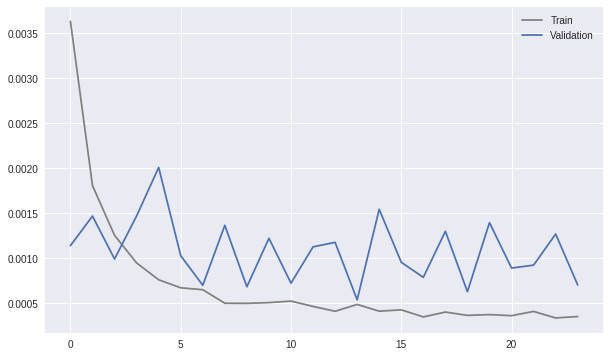

In [0]:
#plotting the loss and validation loss
plt.figure(figsize=(10,6))

#get losses from the history saved
#### Karen: I added /4 here, because I think we should compare the relative loss with data size, validation is 4 times
plt.plot(np.array(history.history['loss'])/4, label='Train', color='gray')  
####
plt.plot(history.history['val_loss'], label='Validation') 

#graph legend
plt.legend()  
plt.show()

In [0]:
x, y = test_gen[0]

#load best saved model
model = load_model('model.h5')

#make predictions
pred = model.predict(x)

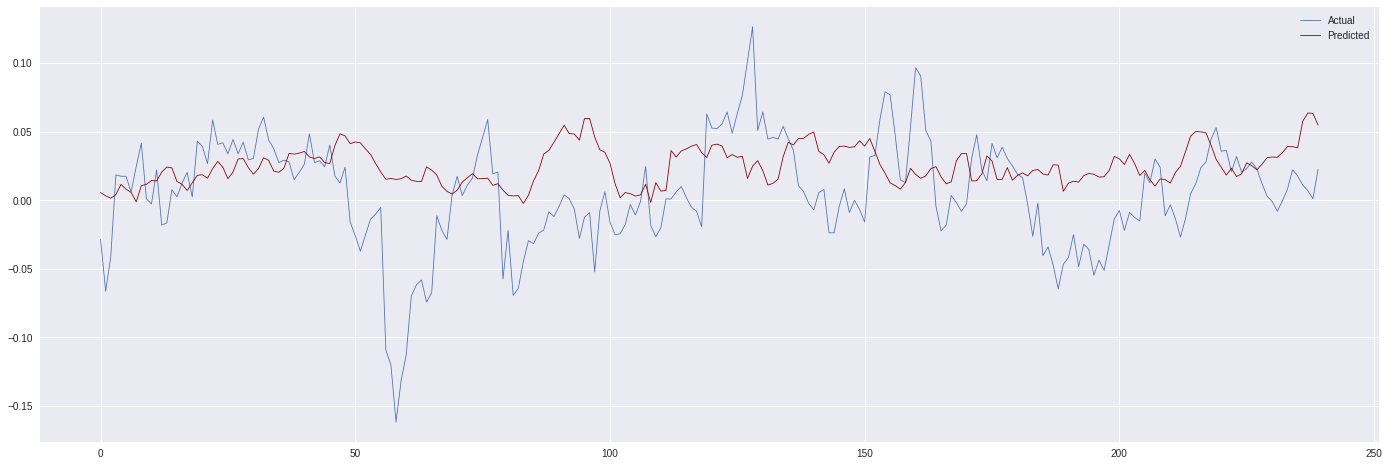

In [0]:
#plot them
plt.figure(figsize=(24,8))

#get length of the results
cycles = np.arange(len(y))

#plot cycles agaonts real
plt.plot(cycles, y, label="Actual", lw=0.8)

#plot cycles against predictions made
plt.plot(cycles, pred, 'maroon', label="Predicted", lw=0.8)

#graph legend
plt.legend()

plt.show()

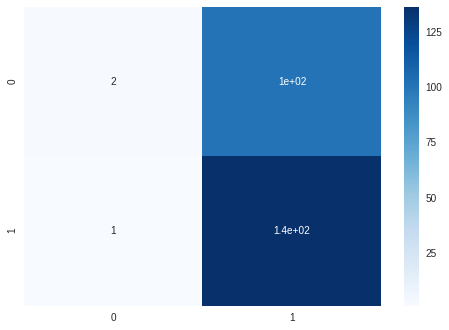

In [0]:
pred_binary = np.where(pred.ravel()>0, 1, 0)
y_binary = np.where(y>0, 1, 0)

cm = confusion_matrix(y_binary, pred_binary)
sns.heatmap(cm, annot=True, cmap='Blues')

In [0]:
print(classification_report(y_binary, pred_binary))

print ('Accuracy: %s' % (accuracy_score(y_binary, pred_binary)*100))

              precision    recall  f1-score   support

           0       0.67      0.02      0.04       103
           1       0.57      0.99      0.73       137

   micro avg       0.57      0.57      0.57       240
   macro avg       0.62      0.51      0.38       240
weighted avg       0.61      0.57      0.43       240

Accuracy: 57.49999999999999


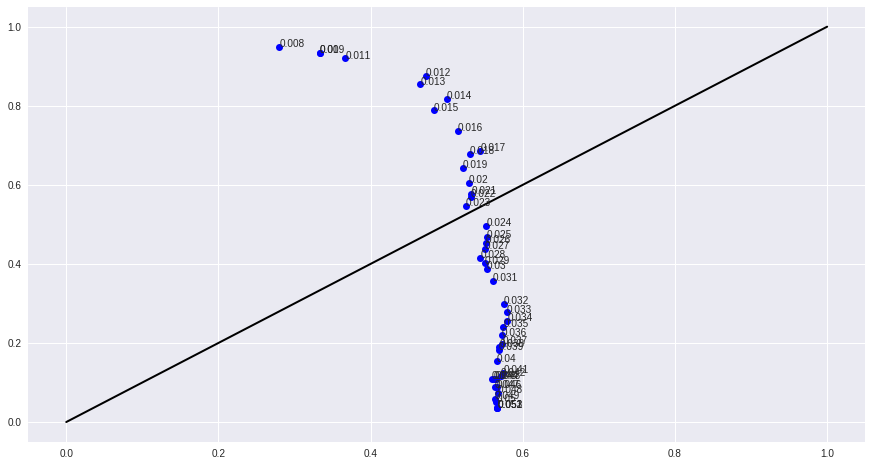

In [0]:
#### Plot something similar to ROC curve.  

plt.figure(figsize=(15,8))
plt.plot([0, 1], [0, 1], color = 'black', linewidth = 2)
y_binary = np.where(y>0, 1, 0)
for cutoff in np.arange(np.min(pred.ravel())+0.01,np.max(pred.ravel())-0.01,0.001): 
    pred_binary = np.where(pred.ravel()>cutoff, 1, 0)
    

    count_positive = np.sum(y_binary)
    count_negative = len(y_binary) - count_positive
    count_true_positive = np.sum(y_binary * pred_binary)
    count_false_positive = np.sum( pred_binary > y_binary )
    count_true_negative = np.sum( (pred_binary == y_binary) * (y_binary ==0 ))
    count_false_negative = np.sum(pred_binary < y_binary)
    true_positive_rate = count_true_positive/(count_true_positive + count_false_negative)
    false_negative_rate = count_false_negative/(count_true_negative + count_false_negative)
    

    plt.plot(false_negative_rate, true_positive_rate, 'bo')
    plt.annotate(s=round(cutoff, 3), xy=(false_negative_rate, true_positive_rate))

In [0]:
'''apple_df_2009 = apple_df[apple_df.time>='2009-01-01']
apple_x = apple_df_2009[[ 'close_open_diff', 'urgency', 'relevance','sentimentClass', 'sentimentNegative', 'sentimentNeutral', 'sentimentPositive','noveltyCount3D', 'noveltyCount5D', 'noveltyCount7D', 'volumeCounts3D', 'volumeCounts5D', 'volumeCounts7D', 'returnsOpenPrevMktres1', 'returnsClosePrevRaw1', 'returnsOpenPrevRaw10', 'returnsOpenPrevMktres10']]
apple_x = np.array(apple_x)

apple_y = apple_df_2009['returnsOpenNextMktres10']
apple_y = np.array(apple_y)'''